<a href="https://colab.research.google.com/github/Williamyan123/Cas-Score-Prediction/blob/master/Efficiency_1dCNN_Cas_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

import theano
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed

%matplotlib inline

In [4]:
# import dataset as a dataframe
df = pd.read_csv("Final Processed Cas13 data.csv")
df.head()




,GuideName,GuideSeq,TargetSite,GuideScores,MismatchNumber
0,crRNA0001,GGACAGGTGGGCGTGGCCCGAGC,CCTGTCCACCCGCACCGGGCTCG,0.041854,0
1,crRNA0001,TGACAGGTGGGCGTGGCCCGAGC,CCTGTCCACCCGCACCGGGCTCG,-0.045263,1
2,crRNA0001,GTACAGGTGGGCGTGGCCCGAGC,CCTGTCCACCCGCACCGGGCTCG,0.098379,1
3,crRNA0001,GGCCAGGTGGGCGTGGCCCGAGC,CCTGTCCACCCGCACCGGGCTCG,-0.108138,1
4,crRNA0001,GGAGAGGTGGGCGTGGCCCGAGC,CCTGTCCACCCGCACCGGGCTCG,-0.488689,1


In [ ]:
# one-hot encode the quartile data
'''df = pd.concat([df, pd.get_dummies(df['Q'], prefix = 'Q')], axis = 1)
del df['Q']

df.head()'''

"df = pd.concat([df, pd.get_dummies(df['Q'], prefix = 'Q')], axis = 1)\ndel df['Q']\n\ndf.head()"

In [ ]:
# extract gRNA sequences from dataframe into a numpy array
guide = df['GuideSeq']
guide = guide[pd.notnull].to_numpy()
print(guide)

# extract target site sequences from dataframe into a numpy array
target = df['TargetSite']
target = target[pd.notnull].to_numpy()
print(target)

#extract the guide score into a numpy array
y=df.GuideScores
y = y[pd.notnull].to_numpy()
print(y)
print(len(y))

In [ ]:
plt.plot(guide[1:100],y[1:100])

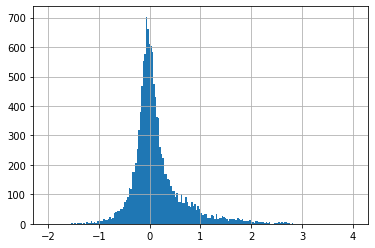

In [7]:
import math

gscores = []
gscores = df.GuideScores.to_numpy()
gscores = np.sort(gscores)
x = list(range(len(guide)))
#plt.plot(gscores, x)
#plt.show()


df['GuideScores'].hist(bins = 200, range = [-2, 4])

In [8]:
# splits a string into an array of characters
def split(word): 
    return [char for char in word]  

# transforms a 23 base pair sequence into a one hot encode in the order A, T, G, C
def transform(seq):
  for i in range(len(seq)):
    
    base = seq[i]
    seq.remove(base)

    if base == "A":
      arg = [1,0,0,0]

    elif base == "T":
      arg = [0,1,0,0]

    elif base == "G":
      arg = [0,0,1,0]

    elif base == "C":
      arg = [0,0,0,1]

    else:
      arg = base

    seq.insert(i, arg)

  return seq

In [ ]:
# split target into individual bases
mguide = []
mtarget = []
for i in range(len(guide)):
  mguide.append(split(guide[i]))
  mtarget.append(split(target[i]))

print(mguide)
print(mtarget)
print(mtarget[0])

In [ ]:
# concatenate the mguide and mtarget arrays into the final encoded format (46*4)
x_encoded=[]
for i in range(len(guide)):
  fguide=[]
  # one-hot encoding of mguide
  fguide = transform(mguide[i])
  ftarget=[]
  #one-hot encoding of mtarget
  ftarget = transform(mtarget[i])
  #fguide = np.array(np.expand_dims(fguide, axis = 1))
  #ftarget = np.array(np.expand_dims(ftarget, axis = 1))
  #final_match = ftarget+fguide
  final_match = np.concatenate((fguide, ftarget), axis=1)
  final_match = final_match.reshape(1,184)
  x_encoded.append(final_match)
# test with one encoded format
print(x_encoded[0])
print(guide[0])
print(x_encoded[0].shape)
# x_final=np.array(x_encoded)
# print(x_final[0]))

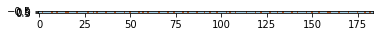

In [11]:
# graph of the encoded format
plt.imshow(x_encoded[0], cmap = 'Paired', interpolation = 'nearest')

In [12]:
#adding a dimension to make it compatible with CNN model
x_encoded = np.expand_dims(x_encoded, axis=3)
x_encoded.shape

(12616, 1, 184, 1)

In [ ]:
#split intotraining and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.25, random_state = 42)

print(x_train[0])
print(x_train[0].shape)
print(y_train[1])

In [21]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import LeakyReLU
from keras.initializers import Constant
import sklearn.metrics as metrics

opt = tf.keras.optimizers.RMSprop(0.001)
dr=0.46
# alp = 0.1
fil= 16
image_shape = (1,184, 1)


model = Sequential()
model.add(Conv1D(filters=fil, kernel_size=8, strides = 8, input_shape=image_shape, activation="relu"))
model.add(Dropout(0.0))
#model.add(MaxPooling2D(pool_size=(2,1)))
model.add(Conv1D(filters=fil, kernel_size=5, input_shape=image_shape, activation="relu"))
model.add(Dropout(0.0))

model.add(Flatten())



model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(dr))
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(dr))


model.add(Dense(1))
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 23, 16)         144       
_________________________________________________________________
dropout (Dropout)            (None, 1, 23, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 19, 16)         1296      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 19, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 304)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30500     
_________________________________________________________________
activation (Activation)      (None, 100)               0

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 5)

In [22]:
history = model.fit(x_train, 
                   y_train, 
                   epochs=200, 
                   batch_size = 256,
                  callbacks=[early_stop],
                   validation_split=0.1)




Epoch 1/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2528 - mse: 0.2528 - val_loss: 0.2389 - val_mse: 0.2389
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2413 - mse: 0.2413 - val_loss: 0.2317 - val_mse: 0.2317
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2300 - mse: 0.2300 - val_loss: 0.2013 - val_mse: 0.2013
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2214 - mse: 0.2214 - val_loss: 0.2002 - val_mse: 0.2002
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2127 - mse: 0.2127 - val_loss: 0.1914 - val_mse: 0.1914
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2072 - mse: 0.2072 - val_loss: 0.2034 - val_mse: 0.2034
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2008 - mse: 0.2008 - val_loss: 0.1859 - val_mse: 0.1859
Epoch 8/200
34/34 [==============================] - 0s 5ms/step - loss: 0.1976 - m

In [23]:
hist=pd.DataFrame(history.history)
hist['Epoch'] = history.epoch
hist.head()


,loss,mse,val_loss,val_mse,Epoch
0,0.252847,0.252847,0.238858,0.238858,0
1,0.241327,0.241327,0.231735,0.231735,1
2,0.229995,0.229995,0.201337,0.201337,2
3,0.221424,0.221424,0.200176,0.200176,3
4,0.212725,0.212725,0.191373,0.191373,4


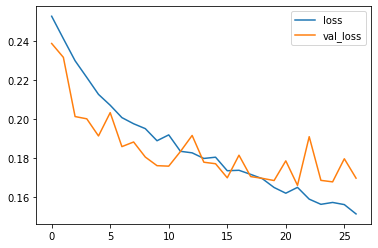

In [24]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [25]:
from sklearn.metrics import r2_score
training_pred =model.predict(x_train)
training_label=y_train

R_squared_training=r2_score(training_label, training_pred)
print(R_squared_training)

0.4515626695475988


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
kf = KFold(n_splits = 8)
kf.get_n_splits(x_encoded)

scores = []

early_stop = EarlyStopping(monitor='val_loss', patience = 5)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
for train_index, test_index in kf.split(x_encoded):
  #print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_test = x_encoded[train_index], x_encoded[test_index]
  y_train, y_test = y[train_index], y[test_index]

  result = model.fit(x_train, 
                   y_train, 
                   epochs=100, 
                   batch_size = 128,
                   validation_split=0.2,
                   callbacks = [early_stop])
  
  print(result.history)
  losses = pd.DataFrame(model.history.history)
  losses[['loss','val_loss']].plot()


print(scores)
print(np.mean(scores))
print(np.std(scores, axis=0))